# **Question 1:**

In [ ]:
import os
import numpy as np
import cv2
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy import vstack
from numpy.random import rand
from numpy.random import randn
from numpy.random import randint
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Input, BatchNormalization, Reshape, LeakyReLU, Conv2DTranspose, Conv2D, Dropout, ZeroPadding2D, UpSampling2D, GaussianNoise
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.datasets.cifar10 import load_data
from keras.models import load_model
from matplotlib.pyplot import figure
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

## Part 1: Dataset loading

### Loading Stanford-car dataset:

In [ ]:
!pip install -q kaggle
from google.colab import files 
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!ls
#uploaded = files.upload()
!kaggle datasets download -d jessicali9530/stanford-cars-dataset
!unzip '/content/stanford-cars-dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: cars_train/cars_train/03145.jpg  
  inflating: cars_train/cars_train/03146.jpg  
  inflating: cars_train/cars_train/03147.jpg  
  inflating: cars_train/cars_train/03148.jpg  
  inflating: cars_train/cars_train/03149.jpg  
  inflating: cars_train/cars_train/03150.jpg  
  inflating: cars_train/cars_train/03151.jpg  
  inflating: cars_train/cars_train/03152.jpg  
  inflating: cars_train/cars_train/03153.jpg  
  inflating: cars_train/cars_train/03154.jpg  
  inflating: cars_train/cars_train/03155.jpg  
  inflating: cars_train/cars_train/03156.jpg  
  inflating: cars_train/cars_train/03157.jpg  
  inflating: cars_train/cars_train/03158.jpg  
  inflating: cars_train/cars_train/03159.jpg  
  inflating: cars_train/cars_train/03160.jpg  
  inflating: cars_train/cars_train/03161.jpg  
  inflating: cars_train/cars_train/03162.jpg  
  inflating: cars_train/cars_train/03163.jpg  
  inflating: cars_train/cars_train/03164.jpg  
  inflati

In [ ]:
data = [] 
for files in os.listdir('/content/cars_train/cars_train'):
  image = cv2.imread('/content/cars_train/cars_train/'+files)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image, (28,28), interpolation =  cv2.INTER_LANCZOS4)
  image = image.astype('float32')
  image = image/255.0
  data.append(image)

for files in os.listdir('/content/cars_test/cars_test'):
  image = cv2.imread('/content/cars_test/cars_test/'+files)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image, (28,28), interpolation =  cv2.INTER_LANCZOS4)
  image = image.astype('float32')
  image = image/255.0
  data.append(image)
data = np.array(data)
dataset = expand_dims(data, axis=-1)
dataset.shape

(16185, 28, 28, 1)

### Loading Cifar-10 Dataset:

In [ ]:
# load cifar10 dataset
(trainX, _), (_, _) = load_data()
# convert from unsigned ints to floats
X = trainX.astype('float32')
# scale from [0,255] to [-1,1]
dataset = (X - 127.5) / 127.5
dataset.shape

170500096/170498071 [==============================] - 6s 0us/step


(50000, 32, 32, 3)

## Part 2: Discriminator

In [ ]:
def define_discriminator(in_shape=(28, 28, 1)):
    model = Sequential()
    # normal
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    # downsample 32x32 -> 16x16
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    # downsample 16x16 -> 8x8
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    # downsample 8x8 -> 4x4
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    # Output layer
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    #model.summary()
    return model

## Part 3: Generator

In [ ]:
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, kernel_size=3, strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(64, kernel_size=3, strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(1, kernel_size=3, activation='tanh', padding='same'))
    model.summary()
    return model

## Part 4: Training

In [ ]:
def define_gan(g_model, d_model):
    # Freezing the layers
    d_model.trainable = False
    model = Sequential()
    # add generator to the model
    model.add(g_model)
    # add discriminator to the model
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y


# create and save a plot of generated images
def save_plot(examples, epoch, n=4):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap="gray")
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  # save plot
  save_plot(x_fake, epoch)
  # save the generator model tile file
  filename = 'generator_model_%03d.h5' % (epoch + 1)
  g_model.save(filename)


def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  d_loss_arr = []
  g_loss_arr = []
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      # randomly select real image
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generate fake samples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # create training set for the discriminator
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      # update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
      d_loss_arr.append(d_loss)
      g_loss_arr.append(g_loss)
      # evaluate the model performance, sometimes
    if (i+1) % 10 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)
  return d_loss_arr, g_loss_arr


# size of the latent space
latent_dim = 200
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# train model
d_loss_arr, g_loss_arr = train(g_model, d_model, gan_model, dataset, latent_dim, 50000, 16)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Streaming output truncated to the last 5000 lines.
>271, 341/1011, d=0.379, g=1.124
>271, 342/1011, d=0.492, g=1.158
>271, 343/1011, d=0.555, g=1.446
>271, 344/1011, d=0.279, g=1.622
>271, 345/1011, d=0.438, g=2.017
>271, 346/1011, d=0.718, g=1.468
>271, 347/1011, d=0.443, g=1.905
>271, 348/1011, d=0.514, g=1.635
>271, 349/1011, d=0.573, g=1.489
>271, 350/1011, d=0.935, g=1.674
>271, 351/1011, d=0.432, g=1.336
>271, 352/1011, d=0.428, g=1.936
>271, 353/1011, d=0.610, g=1.545
>271, 354/1011, d=0.840, g=1.512
>271, 355/1011, d=0.491, g=1.400
>271, 356/1011, d=0.746, g=1.460
>271, 357/1011, d=0.572, g=1.330
>271, 358/1011, d=0.508, g=1.317
>271, 359/1011, d=0.805, g=1.082
>271, 360/1011, d=0.350, g=0.591
>271, 361/1011, d=0.374, g=0.638
>271, 362/1011, d=0.626, g=0.576
>271, 363/1011, d=0.789, g=1.284
>271, 364/1011, d=0.303, g=1.300
>271, 365/1011, d=0.444, g=1.487
>271, 366/1011, d=0.473, g=1.629
>271, 367/1011, d=0.601, g=1.444
>271, 368/1011, d=0.451, g=2.010
>271, 369/1011, d=0.511, 

## Part 5: Loss curve

In [ ]:
# plotting the metrics
plt.plot(d_loss_arr)
plt.plot(g_loss_arr)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

## Part 6: Generate images

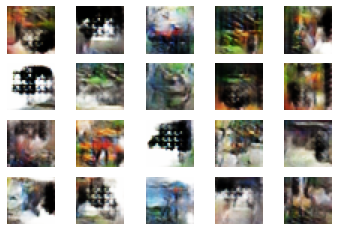

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# plot the generated images
def create_plot(examples, n):
	# plot images
  #figure(figsize=(100, 100))
  for i in range(n):
    # define subplot
    pyplot.subplot(4, 5, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(examples[i])
  pyplot.show()
 
def generate_samples(n):
  # load model
  model = load_model('generator_model_100.h5')
  # generate images
  latent_points = generate_latent_points(100, n)
  # generate images
  X = model.predict(latent_points)
  # scale from [-1,1] to [0,1]
  X = (X + 1) / 2.0
  # plot the result
  create_plot(X, n)

generate_samples(20)

## Part 7(c): VGG-16 as discriminator 

Streaming output truncated to the last 5000 lines.
>25, 74/195, d=0.229, g=0.091
>25, 75/195, d=0.214, g=0.104
>25, 76/195, d=0.234, g=0.118
>25, 77/195, d=0.165, g=0.125
>25, 78/195, d=0.199, g=0.093
>25, 79/195, d=0.170, g=0.123
>25, 80/195, d=0.266, g=0.144
>25, 81/195, d=0.222, g=0.128
>25, 82/195, d=0.186, g=0.167
>25, 83/195, d=0.272, g=0.164
>25, 84/195, d=0.227, g=0.166
>25, 85/195, d=0.196, g=0.141
>25, 86/195, d=0.242, g=0.135
>25, 87/195, d=0.214, g=0.179
>25, 88/195, d=0.220, g=0.206
>25, 89/195, d=0.140, g=0.303
>25, 90/195, d=0.208, g=0.280
>25, 91/195, d=0.324, g=0.381
>25, 92/195, d=0.228, g=0.421
>25, 93/195, d=0.269, g=0.377
>25, 94/195, d=0.295, g=0.424
>25, 95/195, d=0.338, g=0.325
>25, 96/195, d=0.389, g=0.280
>25, 97/195, d=0.538, g=0.264
>25, 98/195, d=0.435, g=0.354
>25, 99/195, d=0.418, g=0.348
>25, 100/195, d=0.492, g=0.415
>25, 101/195, d=0.512, g=0.468
>25, 102/195, d=0.476, g=0.482
>25, 103/195, d=0.731, g=0.310
>25, 104/195, d=0.696, g=0.316
>25, 105/195, 

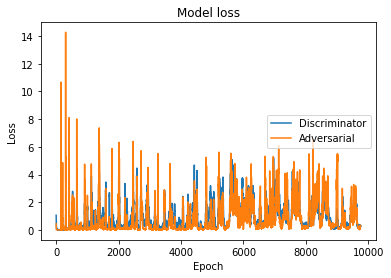

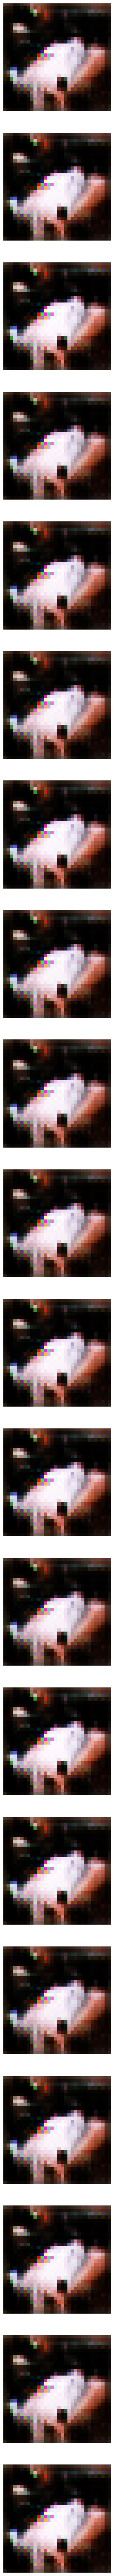

In [ ]:
def define_discriminator(in_shape=(32, 32, 3)):
    vgg16_model = VGG16(input_shape=(64,64,3), weights='imagenet', include_top=False)
    print(vgg16_model.summary())
    model = Sequential()
    model.add(UpSampling2D())
    for layer in vgg16_model.layers[:-3]:
      model.add(layer) 
    for layer in model.layers:
      layer.trainable = False
    # Output layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def define_generator(latent_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 2 * 2
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(BatchNormalization())
    model.add(GaussianNoise(0.1))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((2, 2, 256)))
    # upsample to 4x4
    model.add(Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(GaussianNoise(0.1))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    # upsample to 8x8
    model.add(Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(GaussianNoise(0.1))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(GaussianNoise(0.1))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    # upsample to 32x32
    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(GaussianNoise(0.1))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    # output layer
    model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
    return model

def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y


# create and save a plot of generated images
def save_plot(examples, epoch, n=4):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  # save plot
  save_plot(x_fake, epoch)
  # save the generator model tile file
  filename = 'generator_model_%03d.h5' % (epoch + 1)
  g_model.save(filename)


def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  d_loss_arr = []
  g_loss_arr = []
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      # randomly select real samples 
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generate fake samples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # create training set for the discriminator
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      # update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
      d_loss_arr.append(d_loss)
      g_loss_arr.append(g_loss)
      # evaluate the model performance, sometimes
    if (i+1) % 10 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)
  return d_loss_arr, g_loss_arr


# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
epochs = 50
# train model
d_loss_arr, g_loss_arr = train(g_model, d_model, gan_model, dataset, latent_dim, epochs, 256)

# plotting the metrics
plt.plot(d_loss_arr)
plt.plot(g_loss_arr)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# plot the generated images
def create_plot(examples, n):
	# plot images
  figure(figsize=(100, 100))
  for i in range(n):
    # define subplot
    pyplot.subplot(n, 1, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(examples[i, :, :])
  pyplot.show()
 
def generate_samples(n):
  # load model
  model = load_model('generator_model_050.h5')
  # generate images
  latent_points = generate_latent_points(100, n)
  # generate images
  X = model.predict(latent_points)
  # scale from [-1,1] to [0,1]
  X = (X + 1) / 2.0
  # plot the result
  create_plot(X, n)

generate_samples(20)

# Appendix: Attempts on Stanford Car Data

In [ ]:
#################### Attempt 1 #############################################
def define_discriminator(in_shape=(32,32,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
#################### Attempt 2 #############################################
def define_discriminator(in_shape=(32,32,1)):
  model = Sequential()
  # normal
  model.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=in_shape))
  model.add(ZeroPadding2D(padding=((0,1),(0,1))))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  #model.add(Dropout(0.4))
  #downsample 28 -> 14
  model.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
  model.add(ZeroPadding2D(padding=((0,1),(0,1))))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  #model.add(Dropout(0.4))
  #downsample 14 -> 7
  model.add(Conv2D(256, kernel_size=4, strides=2, padding="same"))
  model.add(ZeroPadding2D(padding=((0,1),(0,1))))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  #model.add(Dropout(0.4))
  #Output layer
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model


In [ ]:
####################### attempt 3 ################################33
def define_discriminator(in_shape=(32,32,1)):
  model = Sequential()
  # normal
  model.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=in_shape))
  model.add(ZeroPadding2D(padding=((0,1),(0,1))))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  #model.add(Dropout(0.4))
  #downsample 28 -> 14
  model.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
  model.add(ZeroPadding2D(padding=((0,1),(0,1))))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  #model.add(Dropout(0.4))
  #downsample 14 -> 7
  model.add(Conv2D(256, kernel_size=4, strides=2, padding="same"))
  model.add(ZeroPadding2D(padding=((0,1),(0,1))))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  #model.add(Dropout(0.4))
  #Output layer
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model

def define_generator(latent_dim):
  model = Sequential()
	# foundation for 4x4 image
  n_nodes = 128 * 7 * 7
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4, 4, 128)))
  model.add(Dropout(0.4))
	# upsample to 14x14
  #model.add(UpSampling2D())
  model.add(Conv2DTranspose(512, (4,4), strides=(2,2), padding='same'))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
  #model.add(UpSampling2D())
  model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(1, (4,4), activation='sigmoid', padding='same'))
  return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        1088      
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 17, 17, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 17, 17, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 128)         131200    
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 10, 10, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 128)       5

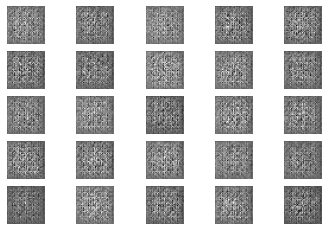

Streaming output truncated to the last 5000 lines.
>91, 52/505, d=0.007, g=1.645
>91, 53/505, d=0.010, g=1.352
>91, 54/505, d=0.010, g=2.447
>91, 55/505, d=0.175, g=4.491
>91, 56/505, d=0.034, g=4.558
>91, 57/505, d=0.007, g=2.839
>91, 58/505, d=0.016, g=3.838
>91, 59/505, d=0.028, g=4.331
>91, 60/505, d=0.144, g=5.720
>91, 61/505, d=0.012, g=6.250
>91, 62/505, d=0.049, g=7.390
>91, 63/505, d=0.005, g=8.378
>91, 64/505, d=0.129, g=6.465
>91, 65/505, d=0.090, g=5.620
>91, 66/505, d=0.043, g=5.975
>91, 67/505, d=0.007, g=6.453
>91, 68/505, d=0.076, g=10.870
>91, 69/505, d=0.029, g=12.708
>91, 70/505, d=0.024, g=10.428
>91, 71/505, d=0.073, g=8.566
>91, 72/505, d=0.006, g=7.225
>91, 73/505, d=0.058, g=7.945
>91, 74/505, d=0.031, g=9.069
>91, 75/505, d=0.042, g=7.377
>91, 76/505, d=0.043, g=5.601
>91, 77/505, d=0.056, g=5.333
>91, 78/505, d=0.010, g=4.759
>91, 79/505, d=0.019, g=4.324
>91, 80/505, d=0.009, g=4.872
>91, 81/505, d=0.005, g=4.110
>91, 82/505, d=0.035, g=7.013
>91, 83/505, d=0

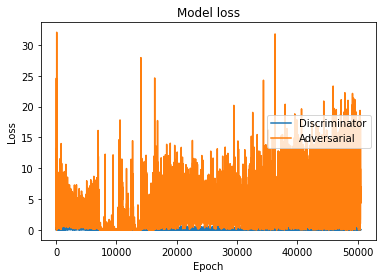

In [ ]:
from keras.utils.vis_utils import plot_model
def define_discriminator(in_shape=(32,32,1)):
  model = Sequential()
  # normal
  model.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=in_shape))
  model.add(ZeroPadding2D(padding=((0,1),(0,1))))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  #model.add(Dropout(0.4))
  #downsample 32 -> 28 
  model.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
  model.add(ZeroPadding2D(padding=((0,1),(0,1))))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  #model.add(Dropout(0.4))
  #downsample 28 -> 14
  model.add(Conv2D(256, kernel_size=4, strides=2, padding="same"))
  model.add(ZeroPadding2D(padding=((0,1),(0,1))))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  #model.add(Dropout(0.4))
  #downsample 14 -> 7
  model.add(Conv2D(512, kernel_size=4, strides=2, padding="same"))
  model.add(ZeroPadding2D(padding=((0,1),(0,1))))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  #Output layer
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model
 
# define model
dis = define_discriminator()
# summarize the model
dis.summary()
# plot the model
plot_model(dis, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

batch_size = 32

def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y


def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(32 * 32 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 32, 32, 1))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y


def train_discriminator(model, dataset, n_iter=100, n_batch=128):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))
  

# define the discriminator model
#model = define_discriminator()
# load image data
#dataset = load_real_samples()
# fit the model
train_discriminator(dis, dataset, batch_size)

def define_generator(latent_dim):
  model = Sequential()
	# foundation for 4x4 image
  n_nodes = 256 * 2 * 2
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((2, 2, 256)))
  model.add(Dropout(0.4))
  # upsample to 4
  model.add(Conv2DTranspose(512, (4,4), strides=(2,2), padding='same'))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
	# upsample to 8
  #model.add(UpSampling2D())
  model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
	# upsample to 16
  #model.add(UpSampling2D())
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  # upsample to 32
  model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(1, (4,4), activation='sigmoid', padding='same'))
  return model

# define the size of the latent space
latent_dim = 100
# define the generator model
gen = define_generator(latent_dim)
# summarize the model
gen.summary()
# plot the model
plot_model(gen, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input


def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y


# size of the latent space
latent_dim = 100
# define the discriminator model
#model = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(gen, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
	# define subplot
	pyplot.subplot(5, 5, 1 + i)
	# turn off axis labels
	pyplot.axis('off')
	# plot single image
	pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
pyplot.show()


# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
#plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

# create and save a plot of generated images
def save_plot(examples, epoch, n=3):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  # save plot
  save_plot(x_fake, epoch)
  # save the generator model tile file
  filename = 'generator_model_%03d.h5' % (epoch + 1)
  g_model.save(filename)

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  d_loss_arr = []
  g_loss_arr = []
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # create training set for the discriminator
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      # update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
      d_loss_arr.append(d_loss)
      g_loss_arr.append(g_loss)
      # evaluate the model performance, sometimes
    if (i+1) % 10 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)
  return d_loss_arr, g_loss_arr
    

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
#dataset = load_real_samples()
epochs = 100
# train model
d_loss_arr, g_loss_arr = train(g_model, d_model, gan_model, dataset, latent_dim, epochs, batch_size)

# plotting the metrics
plt.plot(d_loss_arr)
plt.plot(g_loss_arr)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

In [ ]:
def make_discriminator_model(in_shape=(32,32,1)):
  model = Sequential()
  # normal
  model.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=in_shape))
  model.add(ZeroPadding2D(padding=((0,1),(0,1))))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  #model.add(Dropout(0.4))
  #downsample 32 -> 16
  model.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
  model.add(ZeroPadding2D(padding=((0,1),(0,1))))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  #model.add(Dropout(0.4))
  #downsample 16 -> 8
  model.add(Conv2D(256, kernel_size=4, strides=2, padding="same"))
  model.add(ZeroPadding2D(padding=((0,1),(0,1))))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  #model.add(Dropout(0.4))
  #downsample 8 -> 4
  model.add(Conv2D(512, kernel_size=4, strides=2, padding="same"))
  model.add(ZeroPadding2D(padding=((0,1),(0,1))))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  #model.add(Dropout(0.4))
  #Output layer
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model

dis = make_discriminator_model()
dis.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        1088      
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 17, 17, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 17, 17, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 128)         131200    
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 10, 10, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 128)       5

In [ ]:
latent_dim = 100
def make_generator_model(latent_dim):
  model = Sequential()
	# foundation for 4x4 image
  n_nodes = 128 * 4 * 4
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4, 4, 128)))
  model.add(Dropout(0.4))
	# upsample to 8x8
  #model.add(UpSampling2D())
  model.add(Conv2DTranspose(512, (4,4), strides=(2,2), padding='same'))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
  #model.add(UpSampling2D())
  model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 32x32
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))

  #model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
  #model.add(BatchNormalization(momentum=0.8))
  #model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(1, (4,4), activation='sigmoid', padding='same'))
  return model
  
gen = make_generator_model(latent_dim)
gen.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 512)         1049088   
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 512)        

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# create the gan
gan = define_gan(gen, dis)
# summarize gan model
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 32, 32, 1)         3891585   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 2766529   
Total params: 6,658,114
Trainable params: 3,885,697
Non-trainable params: 2,772,417
_________________________________________________________________


In [ ]:
epochs = 10000
latent_dim = 100
batch_size = 128
iterations_per_epoch = int(len(dataset)/batch_size)
real = np.ones((batch_size, 1), dtype=np.float32)
fake = np.zeros((batch_size, 1), dtype=np.float32)
for epoch in range(epochs):
  for iteration in range(iterations_per_epoch):
    print(epoch, end = ' ')

    #discriminator 
    real_ids = np.random.randint(0, dataset.shape[0], batch_size) 
    real_imgs = dataset[real_ids]
    
    noise_latent = np.random.normal(loc=0.0, scale=1.0, size = (batch_size, latent_dim)).astype(np.float32)
    fake_imgs = gen(noise_latent) #fake images 
    
    dis.train_on_batch(real_imgs, real)
    dis.train_on_batch(fake_imgs, fake)

    noise_latent = np.random.normal(loc=0.0, scale=1.0, size = (batch_size, latent_dim)).astype(np.float32)
    gan.train_on_batch(noise_latent, real)

    if epoch % 500 == 0:
        noise_latent = np.random.normal(loc=0.0, scale=1.0, size = (1, latent_dim)).astype(np.float32)
        fake_imgs = gen(noise_latent)
        plt.imshow(np.array(fake_imgs[0]).reshape(32, 32), cmap = 'gray')
        plt.savefig('output'+str(epoch)+'.png')

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 

In [ ]:
####################################################
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
######################################################
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, half_batch, latent_dim=100):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

In [ ]:
# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	# generate uniform random numbers in [0,1]
	X = rand(32 * 32 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 32, 32, 1))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [ ]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=128):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		#X_fake, y_fake = generate_fake_samples(model, half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

# fit the model
train_discriminator(dis, dataset)

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

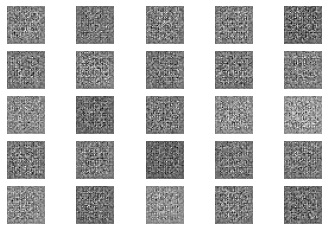

In [ ]:
# size of the latent space
latent_dim = 100
# define the discriminator model
# generate samples
n_samples = 25
X, _ = generate_fake_samples(gen, latent_dim, n_samples)
# scale pixel values from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the generated samples
for i in range(n_samples):
	# define subplot
	pyplot.subplot(5, 5, 1 + i)
	# turn off axis labels
	pyplot.axis('off')
	# plot single image
	pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
pyplot.show()

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=128):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  # save plot
  #save_plot(x_fake, epoch)
  noise_latent = np.random.normal(loc=0.0, scale=1.0, size = (1, latent_dim)).astype(np.float32)
  fake_imgs = gen(noise_latent)
  plt.imshow(np.array(fake_imgs[0, :, :, 0]), cmap = 'gray_r')
  plt.savefig('output'+str(epoch)+'.png')
  # save the generator model tile file
  filename = 'generator_model_%03d.h5' % (epoch+1)
  g_model.save(filename)

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      _, real_acc = d_model.train_on_batch(X_real, y_real)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      _, fake_acc = d_model.train_on_batch(X_fake, y_fake)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, real_acc*100, fake_acc*100, g_loss))
      # evaluate the model performance, sometimes
    if (i+1) % 10 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)
      break

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_31 (Sequential)   (None, 32, 32, 1)         3891585   
_________________________________________________________________
sequential_21 (Sequential)   (None, 1)                 2766529   
Total params: 6,658,114
Trainable params: 3,885,697
Non-trainable params: 2,772,417
_________________________________________________________________
>1, 1/126, d1=100.000, d2=100.000 g=10.373
>1, 2/126, d1=54.688, d2=0.000 g=4.052
>1, 3/126, d1=59.375, d2=100.000 g=0.000
>1, 4/126, d1=98.438, d2=100.000 g=0.000
>1, 5/126, d1=100.000, d2=100.000 g=0.000
>1, 6/126, d1=100.000, d2=100.000 g=0.000
>1, 7/126, d1=100.000, d2=100.000 g=0.000
>1, 8/126, d1=100.000, d2=100.000 g=0.000
>1, 9/126, d1=100.000, d2=100.000 g=0.000
>1, 10/126, d1=100.000, d2=100.000 g=0.000
>1, 11/126, d1=98.438, d2=98.438 g=0.000
>1, 12/126, d1=100.000, d2=100.000 g=0.

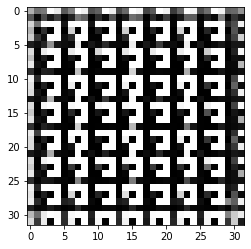

In [ ]:
# size of the latent space
latent_dim = 100
# create the gan
gan_model = define_gan(gen, dis)
# summarize gan model
gan_model.summary()
train(gen, dis, gan_model, dataset, latent_dim, 100)